In [1]:
import os

import pandas as pd
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
def get_transcriptions(path):
    with open(path) as f:
        lines = f.read().split('\n')
        return lines

In [3]:
path = './data/segments/'

In [4]:
lines = get_transcriptions(path+'train.txt')
if (lines[-1]==''):
    lines = lines[:-1]
len(lines)

3550

In [5]:
def parser_line(line):
    id, text, phoneme, note, note_duration, phoneme_duration, slur_note = line.split('|')
    phoneme = phoneme.split(' ')
    note = note.split(' ')
    note_duration = [float(i) for i in note_duration.split(' ')]
    phoneme_duration = [float(i) for i in phoneme_duration.split(' ')]
    slur_note = [int(i) for i in slur_note.split(' ')]
    assert len(phoneme) == len(note_duration) and len(phoneme_duration) == len(slur_note) and len(slur_note) == len(phoneme)
    return id, text, phoneme, note, note_duration, phoneme_duration, slur_note


In [6]:
phoneme_set = set()
note_set = set()
for line in lines:
    id, text, phoneme, note, note_duration, phoneme_duration, slur_note = parser_line(line)
    phoneme_set.update(set(phoneme))
    note_set.update(set(note))

In [7]:
# phoneme_set, note_set

In [62]:
line = lines[4]
line

'2001000005|面对浩瀚的星海我们微小得像尘埃|m ian d ui h ao h an an d e x ing h ai ai ai AP w o m en w ei x iao d e x iang ch en ai ai ai SP|C#4/Db4 C#4/Db4 D#4/Eb4 D#4/Eb4 C#4/Db4 C#4/Db4 D#4/Eb4 D#4/Eb4 E4 D#4/Eb4 D#4/Eb4 E4 E4 G#4/Ab4 G#4/Ab4 A4 G#4/Ab4 rest C#4/Db4 C#4/Db4 C#4/Db4 C#4/Db4 D#4/Eb4 D#4/Eb4 C#4/Db4 C#4/Db4 D#4/Eb4 D#4/Eb4 E4 E4 E4 E4 G#4/Ab4 A4 G#4/Ab4 rest|0.196990 0.196990 0.102120 0.102120 0.304680 0.304680 0.096780 0.096780 0.100220 0.150010 0.150010 0.361460 0.361460 0.221070 0.221070 0.183240 0.478670 0.384620 0.106510 0.106510 0.143020 0.143020 0.169480 0.169480 0.224180 0.224180 0.089360 0.089360 0.414460 0.414460 0.378050 0.378050 0.162790 0.207380 0.317260 0.297040|0.02765 0.16934 0.01874 0.08338 0.0821 0.22258 0.0693 0.02748 0.10022 0.07137 0.07864 0.12471 0.23675 0.12356 0.09751 0.18324 0.47867 0.38462 0.0405 0.06601 0.08303 0.05999 0.04687 0.12261 0.09778 0.1264 0.02321 0.06615 0.11958 0.29488 0.06723 0.31082 0.16279 0.20738 0.31726 0.29704|0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 

In [63]:
id, text, phoneme, note, note_duration, phoneme_duration, slur_note = parser_line(line)

In [95]:
initial_table = ['b', 'p', 'm', 'f',
                'd', 't', 'n', 'l',
                'g', 'k', 'h',
                'j', 'q', 'x',
                'zh', 'ch', 'sh', 'r', 'z', 'c', 's', 'y', 'w']
def merge_note(text, phoneme, note, note_duration):
    # remove the duplicate items in phoneme, note, and note_duration
    # use text to verify the length
    phoneme = phoneme.copy()
    note = note.copy()
    note_duration = note_duration.copy()

    j = -1
    text+=',,,,,,,,,,,,,,'
    text_with_p = phoneme.copy()
    # print(text, text_with_p)
    used_flag = False
    for i in range(len(text_with_p)):
        if text_with_p[i] in ['AP', 'SP']:
            continue
        if j==-1 or phoneme[i] in initial_table or (phoneme[i-1] not in initial_table and phoneme[i] != phoneme[i-1]):
            j+=1
            used_flag = False
        # print(text_with_p)
        text_with_p[i] = text[j] if used_flag == False else '~'
        used_flag = True

    # print(text_with_p)
            

    for i in range(len(phoneme)-1, 0, -1):
        if (note_duration[i] == note_duration[i-1] and phoneme[i-1] in initial_table):
            del note_duration[i]
            del note[i]
            phoneme[i-1]=phoneme[i-1]+phoneme[i]
            del phoneme[i]
            del text_with_p[i]
        elif phoneme[i-1] == phoneme[i]:
            # del note[i]
            # del phoneme[i]
            pass
    
    
    # print(text_with_p)
    # print(note)
    # print(len(text_with_p))
    # print(len(note))

    
    return text_with_p, phoneme, note, note_duration
    
merge_note(text, phoneme, note, note_duration)

(['面',
  '对',
  '浩',
  '瀚',
  '~',
  '的',
  '星',
  '海',
  '~',
  '~',
  'AP',
  '我',
  '们',
  '微',
  '小',
  '得',
  '像',
  '尘',
  '埃',
  '~',
  '~',
  'SP'],
 ['mian',
  'dui',
  'hao',
  'han',
  'an',
  'de',
  'xing',
  'hai',
  'ai',
  'ai',
  'AP',
  'wo',
  'men',
  'wei',
  'xiao',
  'de',
  'xiang',
  'chen',
  'ai',
  'ai',
  'ai',
  'SP'],
 ['C#4/Db4',
  'D#4/Eb4',
  'C#4/Db4',
  'D#4/Eb4',
  'E4',
  'D#4/Eb4',
  'E4',
  'G#4/Ab4',
  'A4',
  'G#4/Ab4',
  'rest',
  'C#4/Db4',
  'C#4/Db4',
  'D#4/Eb4',
  'C#4/Db4',
  'D#4/Eb4',
  'E4',
  'E4',
  'G#4/Ab4',
  'A4',
  'G#4/Ab4',
  'rest'],
 [0.19699,
  0.10212,
  0.30468,
  0.09678,
  0.10022,
  0.15001,
  0.36146,
  0.22107,
  0.18324,
  0.47867,
  0.38462,
  0.10651,
  0.14302,
  0.16948,
  0.22418,
  0.08936,
  0.41446,
  0.37805,
  0.16279,
  0.20738,
  0.31726,
  0.29704])

In [88]:
# for i in [id, text, phoneme, note, note_duration, phoneme_duration, slur_note]:
#     print(len(i))

In [89]:
def get_audio(id, path, sr = 16000):
    wav_path = path+'wavs/'+id+'.wav'
    waveform, sample_rate = torchaudio.load(wav_path)
    if sample_rate != sr:
        waveform = torchaudio.functional.resample(waveform[0].unsqueeze(0), sample_rate, sr)
    return waveform

waveform = get_audio(id, path)

In [90]:
sum(phoneme_duration), waveform.shape[-1]/16000

(5.08939, 5.0894375)

In [156]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = ['SimHei']
import librosa
def melspec(waveform, sr=16000):
    n_fft = 1024
    win_length = None
    hop_length = 512
    n_mels = 128
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm='slaney',
        onesided=True,
        n_mels=n_mels,
        mel_scale="htk",
    )
    melspec = mel_spectrogram(waveform)
    return melspec

def plot_alignment(waveform, text, phoneme, note, note_duration, phoneme_duration, slur_note, sr=16000):
    fontsize = 14
    text_with_p, phoneme_merge, note, note_duration = merge_note(text, phoneme, note, note_duration)
    fig, ax = plt.subplots(3, 1, figsize=(16, 10))
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    [ax1, ax2, ax3] = ax
    # ax1 waveform
    ratio = sr
    ax1.plot(waveform/(max(torch.max(waveform), -torch.min(waveform)))*0.8)
    ax1.set_xlim(0, waveform.size(-1))
    ax1.set_ylim(-1.0, 1.0)
    time_current = 0.
    for i in range(len(phoneme_duration)):
        x0 = ratio * time_current
        time_current += phoneme_duration[i]
        x1 = ratio * time_current
        shift_pos = (phoneme_duration[i]-0.05)*ratio/2 if phoneme_duration[i] > 0.1 else 0.35**ratio
        ax1.axvspan(x0, x1, ymin=0.5, ymax=1, alpha=0.1, color="red")
        ax1.annotate(phoneme[i], (x0+shift_pos, 0.85), color='black', fontsize=fontsize)
    time_current = 0
    for i in range(len(note_duration)):
        x0 = ratio * time_current
        time_current += note_duration[i]
        x1 = ratio * time_current
        ax1.axvspan(x0, x1, ymin=0, ymax=0.5, alpha=0.1, color="blue")
        ax1.annotate(note[i].split('/')[0], (x0+(note_duration[i]-0.05)*ratio/2, -0.85), color='black', fontsize=fontsize)
    # ax2 mel spectrogram
    mel = melspec(waveform)
    ax2.imshow(librosa.power_to_db(mel) , origin='lower', aspect='auto')
    # ax3 information
    ax3.set_ylim(-1.0, 1.0)
    ax3.set_xlim(0, waveform.size(-1))
    y_split = lambda k: [1.0*(i)/k for i in range(k)]
    k = 6
    ys = y_split(k)
    for i in range(k):
        ax3.axhline(y=ys[i]*2-1)
    time_current = 0
    for i in range(len(note_duration)):
        x0 = ratio * time_current
        time_current += note_duration[i]
        x1 = ratio * time_current
        ax3.axvline(x=x1, ymin=ys[1], ymax=ys[4], color="blue")
        ax3.annotate(note[i].split('/')[0], (x0+(note_duration[i]-0.05)*ratio/2, 0.1), color='black', fontsize=fontsize)
        ax3.annotate(text_with_p[i], (x0+(note_duration[i]-0.05)*ratio/2, -0.2), color='black', fontsize=fontsize)
        ax3.annotate(phoneme_merge[i], (x0+(note_duration[i]-0.1)*ratio/2, -0.5), color='black', fontsize=fontsize)
    phoneme *2
    time_current = 0
    for i in range(len(phoneme_duration)):
        x0 = ratio * time_current
        time_current += phoneme_duration[i]
        x1 = ratio * time_current
        ax3.axvline(x=x1, ymin=ys[4], ymax=1, color="pink")
        shift_pos = (phoneme_duration[i]-0.05)*ratio/2 if phoneme_duration[i] > 0.1 else 0.35**ratio
        ax3.annotate(phoneme[i], (x0+shift_pos, 0.8), color='black', fontsize=fontsize)
        ax3.annotate(slur_note[i], (x0+shift_pos, 0.5), color='black', fontsize=fontsize)
    ax3.annotate(text, ((sum(phoneme_duration)-len(text)/8)*ratio/2, -0.9), color='black', fontsize=fontsize)
    fig.tight_layout()

In [165]:
def plot_info(i):
    id, text, phoneme, note, note_duration, phoneme_duration, slur_note = parser_line(lines[i])
    waveform = get_audio(id, path)
    plot_alignment(waveform[0], text, phoneme, note, note_duration, phoneme_duration, slur_note)
    plt.subplots_adjust(wspace =0, hspace =0)
    plt.show()

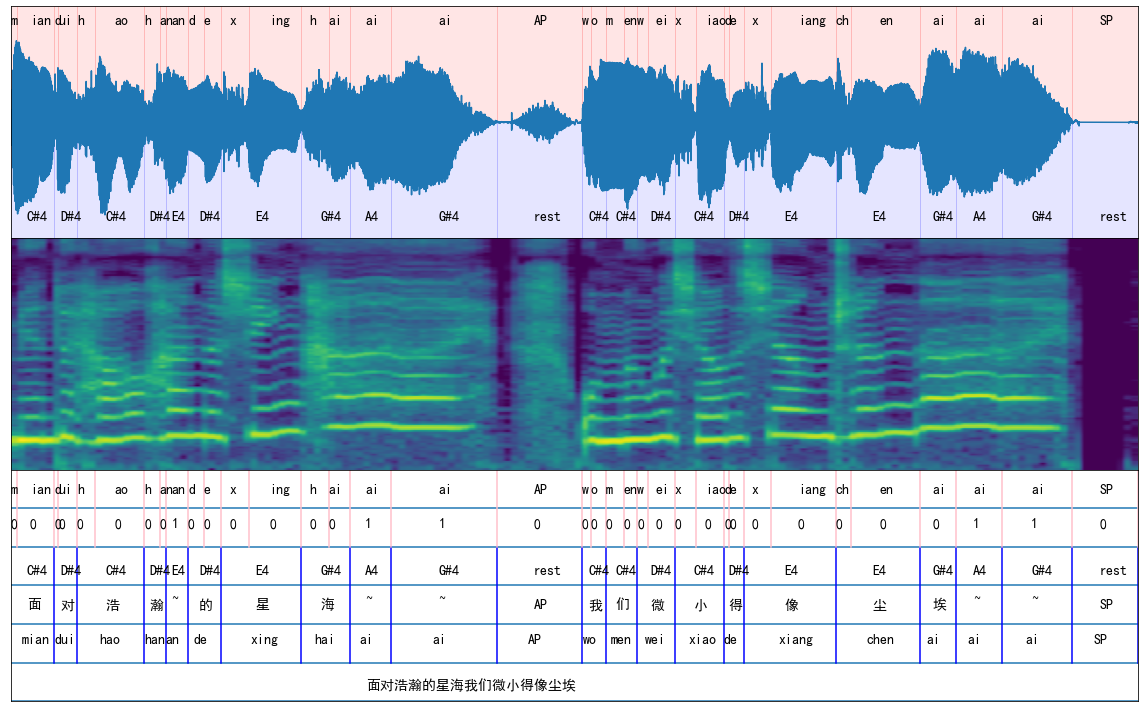

In [166]:
plot_info(4)